# Importing libs

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import seaborn as sns

In [15]:
import os
import PIL
import random

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [17]:
import pathlib
from glob import glob
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Reading input data 

In [19]:
data_dir_train = pathlib.Path("C:/Users/dubey/Downloads/archive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("C:/Users/dubey/Downloads/archive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [20]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Prepare the dataset

In [21]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [24]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [25]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


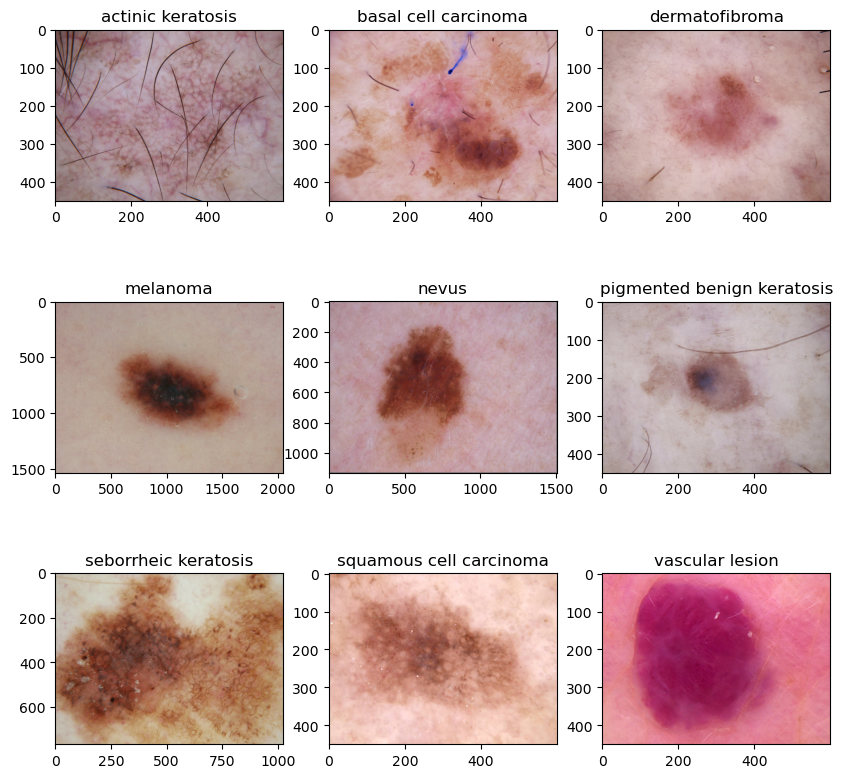

In [26]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [27]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1 : standard Model


In [29]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [30]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [32]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 15s 115ms/step - loss: 2.0278 - accuracy: 0.2193 - val_loss: 1.9449 - val_accuracy: 0.2796
Epoch 2/25
56/56 [==============================] - 5s 87ms/step - loss: 1.8938 - accuracy: 0.2706 - val_loss: 1.6933 - val_accuracy: 0.4362
Epoch 3/25
56/56 [==============================] - 5s 89ms/step - loss: 1.7218 - accuracy: 0.3817 - val_loss: 1.6601 - val_accuracy: 0.4072
Epoch 4/25
56/56 [==============================] - 5s 87ms/step - loss: 1.6163 - accuracy: 0.4107 - val_loss: 1.5736 - val_accuracy: 0.4541
Epoch 5/25
56/56 [==============================] - 5s 87ms/step - loss: 1.6292 - accuracy: 0.4141 - val_loss: 1.7477 - val_accuracy: 0.3512
Epoch 6/25
56/56 [==============================] - 5s 88ms/step - loss: 1.5019 - accuracy: 0.4688 - val_loss: 1.5086 - val_accuracy: 0.4653
Epoch 7/25
56/56 [==============================] - 5s 87ms/step - loss: 1.4626 - accuracy: 0.4810 - val_loss: 1.5612 - val_accuracy: 0.4698
Epoch 8/25


In [104]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss))

4/4 [==============================] - 2s 22ms/step - loss: 5.7211 - accuracy: 0.3962
[INFO] accuracy: 39.62%
[INFO] Loss: 5.721098899841309


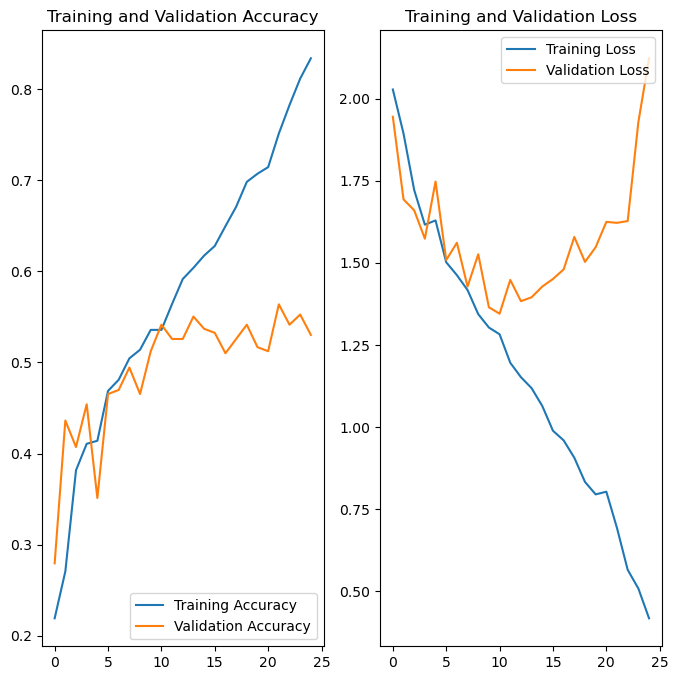

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings :
*   The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 20%. 

*   The training accuracy is just around 70-75% with 25 epochos and the model is yet to learn the many features.

*  data imbalance might be causing the bais to the model.

# Model 2 : Data Augumentation with drop out layer.

In [34]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


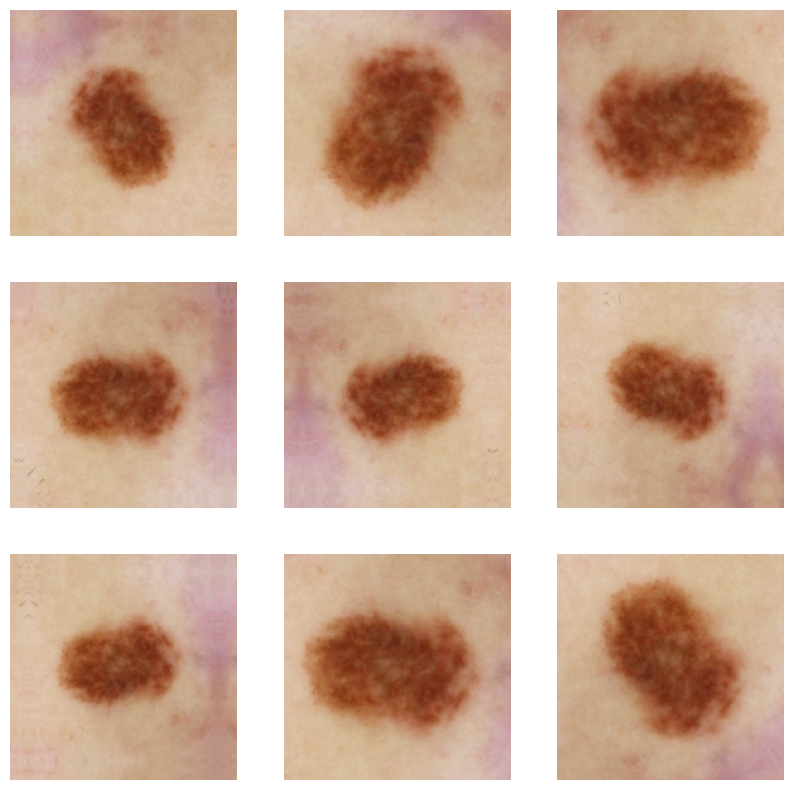

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [36]:
num_classes = 9
model = Sequential(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [37]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 18s 271ms/step - loss: 2.0945 - accuracy: 0.1802 - val_loss: 1.9647 - val_accuracy: 0.2796
Epoch 2/25
56/56 [==============================] - 16s 280ms/step - loss: 1.9224 - accuracy: 0.2751 - val_loss: 1.9062 - val_accuracy: 0.2483
Epoch 3/25
56/56 [==============================] - 16s 278ms/step - loss: 1.7777 - accuracy: 0.3387 - val_loss: 1.6591 - val_accuracy: 0.4027
Epoch 4/25
56/56 [==============================] - 17s 298ms/step - loss: 1.6164 - accuracy: 0.4113 - val_loss: 1.6217 - val_accuracy: 0.4362
Epoch 5/25
56/56 [==============================] - 17s 308ms/step - loss: 1.5847 - accuracy: 0.4319 - val_loss: 1.6706 - val_accuracy: 0.3893
Epoch 6/25
56/56 [==============================] - 17s 305ms/step - loss: 1.5139 - accuracy: 0.4598 - val_loss: 1.5066 - val_accuracy: 0.4698
Epoch 7/25
56/56 [==============================] - 17s 305ms/step - loss: 1.4587 - accuracy: 0.4821 - val_loss: 1.5091 - val_accuracy: 0.5101

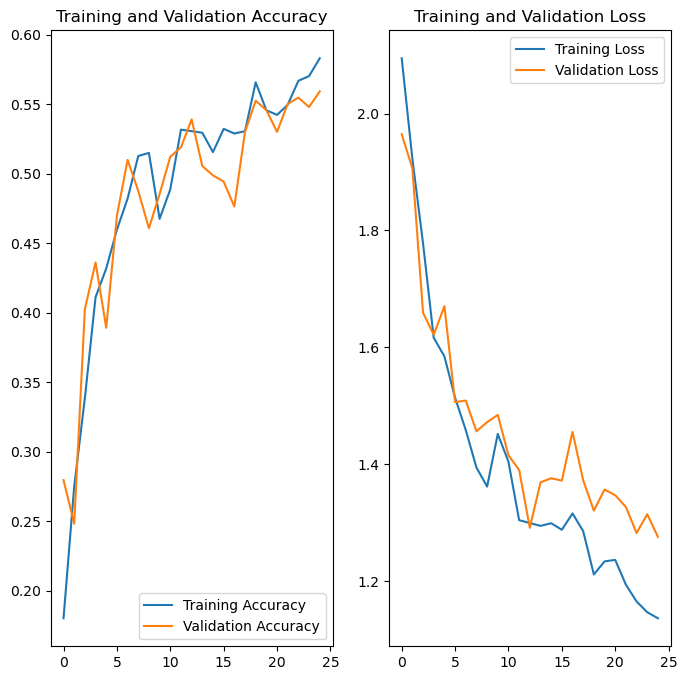

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings 
* With data agumenatation and drop layer, the overfitting of the model is adressed to great extend. Earlier the train and validation accuracy difference was nearly 20%, with latest approach it's reduced to 2-3%. 

* The accuracy of the model is compromised heavily and decreased by fair bit from previous venilla model. 

* Considering above 2 points, there is still a scope of lot of improvement of the model.


# Analysing the class imbalance of the data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

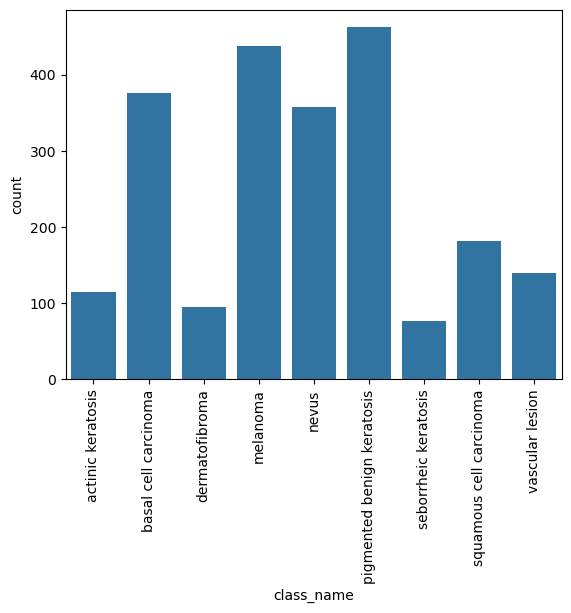

In [44]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

## Findings 
Data is hevily imbalance and hence due to that results and predictions will be baised.

# Augmentor : Class balance

Using Augmentor (https://augmentor.readthedocs.io/en/master/) to create the equal distribution of the class.

In [45]:
!pip install Augmentor

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     -------------------- ----------------- 30.7/57.6 kB 330.3 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 525.1 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 525.1 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 525.1 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 525.1 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 144.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.4 kB ? eta -:--:--
   ---------------------------------------- 78.4/78.4 kB 2.2 MB/s eta 0:00:00


In [62]:
path_to_training_dataset = 'C:/Users/dubey/Downloads/archive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+'/'+i, output_directory='C:/Users/dubey/Downloads/output/'+i+'/output')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C8ADF1C220>: 100%|██████████| 1000/1000 [00:05<00:00, 182.24 Samples/s]                 


Initialised with 376 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C8FD5D08E0>: 100%|██████████| 1000/1000 [00:05<00:00, 176.88 Samples/s]                 


Initialised with 95 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C8FD65C4F0>: 100%|██████████| 1000/1000 [00:05<00:00, 179.68 Samples/s]                 


Initialised with 438 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x1C7D5773880>: 100%|██████████| 1000/1000 [00:27<00:00, 36.18 Samples/s]                 


Initialised with 357 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1C8ADE9AE60>: 100%|██████████| 1000/1000 [00:27<00:00, 36.36 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C73F9B9F60>: 100%|██████████| 1000/1000 [00:06<00:00, 154.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C7D2319540>: 100%|██████████| 1000/1000 [00:13<00:00, 72.53 Samples/s]                 


Initialised with 181 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C8ADF1F3D0>: 100%|██████████| 1000/1000 [00:05<00:00, 167.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C75BA887C0>: 100%|██████████| 1000/1000 [00:05<00:00, 168.72 Samples/s]                 


In [63]:
output_dir = pathlib.Path('C:/Users/dubey/Downloads/output/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

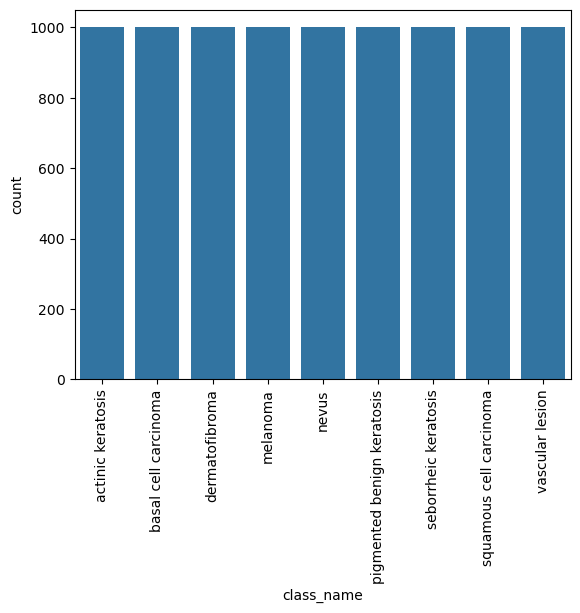

In [64]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Model 3 : Model with Class balance data.

In [65]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [66]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [67]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [106]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [107]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [108]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
225/225 [==============================] - 24s 102ms/step - loss: 1.8076 - accuracy: 0.2839 - val_loss: 1.6722 - val_accuracy: 0.3778
Epoch 2/15
225/225 [==============================] - 23s 99ms/step - loss: 1.4337 - accuracy: 0.4390 - val_loss: 1.3649 - val_accuracy: 0.5011
Epoch 3/15
225/225 [==============================] - 22s 98ms/step - loss: 1.2522 - accuracy: 0.5201 - val_loss: 1.1485 - val_accuracy: 0.5622
Epoch 4/15
225/225 [==============================] - 22s 98ms/step - loss: 1.0806 - accuracy: 0.5803 - val_loss: 1.0601 - val_accuracy: 0.5700
Epoch 5/15
225/225 [==============================] - 22s 98ms/step - loss: 0.8980 - accuracy: 0.6529 - val_loss: 0.8921 - val_accuracy: 0.6667
Epoch 6/15
225/225 [==============================] - 22s 98ms/step - loss: 0.7302 - accuracy: 0.7206 - val_loss: 0.6899 - val_accuracy: 0.7589
Epoch 7/15
225/225 [==============================] - 22s 98ms/step - loss: 0.6334 - accuracy: 0.7690 - val_loss: 0.9305 - val_accuracy

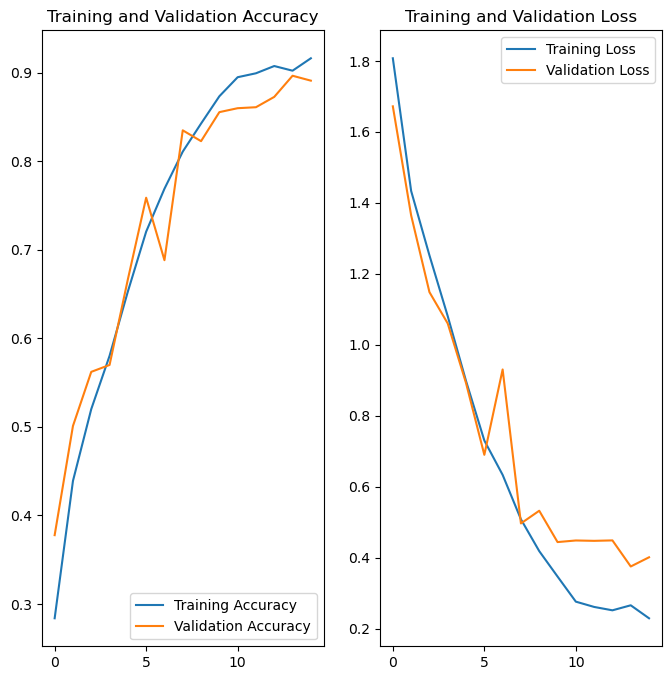

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings :
* After rebalance/resampling of the data (that gave equal proportion of data )and raised the accuray of the mdoel to 90%. This addressed the low accurty problem.

*  overfitting probelm is adressed and now difference between train and val set is nearly 4-5% diff. 

* with these results it's conclusive that current module with rebalanced data is the best module.


# Evaluation.

In [110]:
top_model_weights_path = 'C:/Users/dubey/Downloads/output/cnn_fc_model.h5'
model.save_weights(top_model_weights_path)

In [99]:
path_to_testing_dataset = 'C:/Users/dubey/Downloads/archive/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_testing_dataset+'/'+i, output_directory='C:/Users/dubey/Downloads/output_test/'+i+'/output')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(10)

Initialised with 16 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1C7D25881F0>: 100%|██████████| 10/10 [00:00<00:00, 123.45 Samples/s]


Initialised with 16 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C7D255A140>: 100%|██████████| 10/10 [00:00<00:00, 147.06 Samples/s]                 


Initialised with 16 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C7D2588130>: 100%|██████████| 10/10 [00:03<00:00,  2.53 Samples/s] 


Initialised with 16 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1C7D255B640>: 100%|██████████| 10/10 [00:00<00:00, 33.33 Samples/s]                 


Initialised with 16 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1022x767 at 0x1C7D25883A0>: 100%|██████████| 10/10 [00:00<00:00, 36.36 Samples/s]


Initialised with 16 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C7D25586A0>: 100%|██████████| 10/10 [00:00<00:00, 96.16 Samples/s]                 


Initialised with 3 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C7D2558610>: 100%|██████████| 10/10 [00:00<00:00, 55.87 Samples/s]                 


Initialised with 16 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=6668x4419 at 0x1C7D3762560>: 100%|██████████| 10/10 [00:04<00:00,  2.50 Samples/s]                


Initialised with 3 image(s) found.
Output directory set to C:/Users/dubey/Downloads/output_test/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C7D2588A00>: 100%|██████████| 10/10 [00:00<00:00, 126.58 Samples/s]


In [111]:
output_test_dir = pathlib.Path('C:/Users/dubey/Downloads/output_test/')
image_count_test = len(list(output_test_dir.glob('*/output/*.jpg')))
print(image_count_test)

90


In [112]:
test_aug_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_test_dir,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 90 files belonging to 9 classes.
Using 81 files for validation.


In [114]:
(eval_loss, eval_accuracy) = model.evaluate(val_ds, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss))

57/57 [==============================] - 2s 30ms/step - loss: 0.4011 - accuracy: 0.8911
[INFO] accuracy: 89.11%
[INFO] Loss: 0.4010976552963257
